#EfficientNet-V2

There are 3 versions. Small, medium and large. I will probably go for small in my first try

In [ ]:
#importing all packages
import copy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.models import (
    efficientnet_v2_m,
    EfficientNet_V2_M_Weights
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bglemser","key":"1b0d7921dada59101501451e17cb9c72"}'}

In [ ]:
# Kaggle konfiguration
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 1. Kaggle Download & Unzip (automatisch)
import os

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# Kaggle API: Dataset herunterladen
if not os.path.exists("datasciencebowl.zip"):
    !kaggle competitions download -c datasciencebowl --quiet

# Hauptzip entpacken
if not os.path.exists(DATA_DIR):
    !unzip -q datasciencebowl.zip -d datasciencebowl

# Train, Test, SampleSubmission entpacken
!unzip -oq datasciencebowl/train.zip -d datasciencebowl/train
!unzip -oq datasciencebowl/test.zip -d datasciencebowl/test
!unzip -oq datasciencebowl/sampleSubmission.csv.zip -d datasciencebowl

# Doppelten train-Ordner zusammenführen (rsync)
if os.path.exists("datasciencebowl/train/train"):
    !rsync -a --ignore-existing datasciencebowl/train/train/ datasciencebowl/train/
    !rm -r datasciencebowl/train/train

print("Done!")

Done!


In [ ]:
# 3. Custom dataset
class ImageFolderDataset(Dataset): #für pytorch dataset
    def __init__(self, root_dir, classes=None, transform=None): #define souces of data, no transformations yet
        self.samples = []
        if classes is None:
            classes = sorted([
                d for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
            ])
        self.label2idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((cls, os.path.join(cls_path, f)))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, path = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label2idx[label]

In [ ]:
# 4. Filter Classes by Threshold
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(TRAIN_DIR, cls))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    for cls in classes
}

df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
df_counts = df_counts.sort_values("num_images", ascending=False)

threshold = 114 #classes with less than 114 images are removed
classes_filtered = df_counts[df_counts["num_images"] > threshold].index.tolist()
print(f"Filtered classes: {len(classes_filtered)}")

Filtered classes: 60


In [ ]:
# 5. Compute global mean and std
pixel_sum, pixel_sq_sum, pixel_count = 0, 0, 0
for cls in tqdm(classes_filtered, desc="Calculating mean/std"):
    cls_path = os.path.join(TRAIN_DIR, cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            img = np.array(Image.open(os.path.join(cls_path, f)).convert("RGB"), dtype=np.float32)
            pixel_sum += img.sum()
            pixel_sq_sum += (img ** 2).sum()
            pixel_count += img.size

global_mean = pixel_sum / pixel_count
global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean**2)
print(f"Global mean: {global_mean:.2f}, Global std: {global_std:.2f}")

mean = global_mean / 255.0
std  = global_std / 255.0

Calculating mean/std: 100%|██████████| 60/60 [00:07<00:00,  8.15it/s]

Global mean: 241.34, Global std: 40.30


In [ ]:
# 6. Transformations
IMG_SIZE = 112     # then 320, then 384

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean]*3, std=[std]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean]*3, std=[std]*3)
])

In [ ]:
# 7. Dataset and split
full_dataset = ImageFolderDataset(root_dir=TRAIN_DIR, classes=classes_filtered)

labels = [full_dataset.label2idx[label] for label, _ in full_dataset.samples]
indices = list(range(len(full_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)

train_ds.dataset.transform = train_transform
val_ds.dataset.transform   = val_transform

In [ ]:
# 8. DataLoaders
batch_size = 16   # risk of CUDA out of memory if batch size is too large, start with 8, then 16, then 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

torch.Size([16, 3, 112, 112]) torch.Size([16])
{'trichodesmium_puff': 0, 'chaetognath_other': 1, 'copepod_cyclopoid_oithona_eggs': 2, 'protist_other': 3, 'detritus_other': 4, 'copepod_cyclopoid_oithona': 5, 'acantharia_protist': 6, 'chaetognath_non_sagitta': 7, 'trichodesmium_bowtie': 8, 'hydromedusae_solmaris': 9, 'appendicularian_s_shape': 10, 'chaetognath_sagitta': 11, 'copepod_calanoid': 12, 'trichodesmium_tuft': 13, 'protist_noctiluca': 14, 'echinoderm_larva_seastar_brachiolaria': 15, 'appendicularian_slight_curve': 16, 'diatom_chain_string': 17, 'fecal_pellet': 18, 'diatom_chain_tube': 19, 'siphonophore_calycophoran_rocketship_young': 20, 'tunicate_doliolid': 21, 'unknown_unclassified': 22, 'tunicate_doliolid_nurse': 23, 'hydromedusae_shapeA': 24, 'detritus_filamentous': 25, 'artifacts': 26, 'echinoderm_larva_seastar_bipinnaria': 27, 'protist_fuzzy_olive': 28, 'detritus_blob': 29, 'tunicate_partial': 30, 'hydromedusae_narco_young': 31, 'unknown_blobs_and_smudges': 32, 'radiolaria

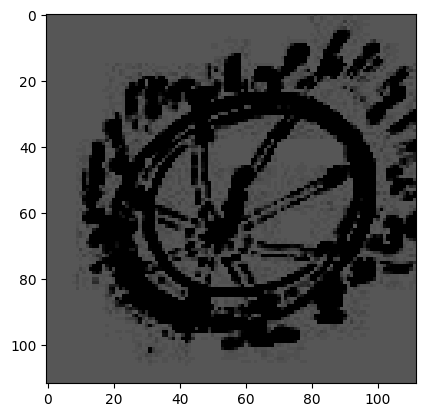

In [ ]:
#small test if everything worked
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

#check one class
num_classes = len(train_ds.dataset.label2idx)

print(train_ds.dataset.label2idx)

#visualise image
import matplotlib.pyplot as plt

img = images[0].permute(1,2,0)
plt.imshow(img)
plt.show()

#EfficentNet V2-S

In [ ]:
#import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#working on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
#get number of classes
base_ds = train_ds.dataset if hasattr(train_ds, "dataset") else train_ds
num_classes = len(base_ds.label2idx)

print("Num classes:", num_classes)

#load the pretrained weights and the model
weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_s(weights=weights)

#replace classifier head
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

#get model to GPU
model = model.to(device)

#loss function
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)





Num classes: 60
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 91.5MB/s]


In [ ]:
from sklearn.metrics import f1_score
import torch
import matplotlib.pyplot as plt

num_epochs = 10

# Listen zum Speichern
train_losses = []
val_losses = []       # <-- vorher fehlend
val_f1_macros = []
val_f1_weighteds = []  # falls du weighted F1 nutzen willst

for epoch in range(num_epochs):

    # -------- TRAIN --------
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # -------- VALIDATION --------
    model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")

    val_f1_macros.append(f1_macro)
    val_f1_weighteds.append(f1_weighted)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, "
        f"Val Loss={val_loss:.4f}, "
        f"Val F1 Macro={f1_macro:.4f}, "
        f"Val F1 Weighted={f1_weighted:.4f}"
    )

print("Training finished.")


Epoch 1: Train Loss=1.2837, Val Loss=0.8534, Val F1 Macro=0.6722, Val F1 Weighted=0.7190
Epoch 2: Train Loss=0.7799, Val Loss=0.7622, Val F1 Macro=0.7094, Val F1 Weighted=0.7525
Epoch 3: Train Loss=0.6281, Val Loss=0.7103, Val F1 Macro=0.7350, Val F1 Weighted=0.7599
Epoch 4: Train Loss=0.5242, Val Loss=0.7285, Val F1 Macro=0.7427, Val F1 Weighted=0.7705
Epoch 5: Train Loss=0.4185, Val Loss=0.7979, Val F1 Macro=0.7201, Val F1 Weighted=0.7491
Epoch 6: Train Loss=0.3481, Val Loss=0.8271, Val F1 Macro=0.7323, Val F1 Weighted=0.7574
Epoch 7: Train Loss=0.2803, Val Loss=0.8765, Val F1 Macro=0.7314, Val F1 Weighted=0.7602
Epoch 8: Train Loss=0.2249, Val Loss=0.9389, Val F1 Macro=0.7328, Val F1 Weighted=0.7570
Epoch 9: Train Loss=0.1965, Val Loss=0.9876, Val F1 Macro=0.7267, Val F1 Weighted=0.7526
Epoch 10: Train Loss=0.1768, Val Loss=0.9646, Val F1 Macro=0.7316, Val F1 Weighted=0.7601
Training finished.


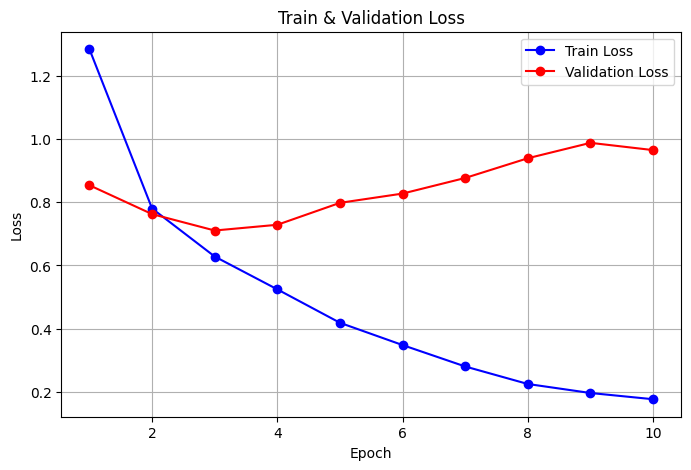

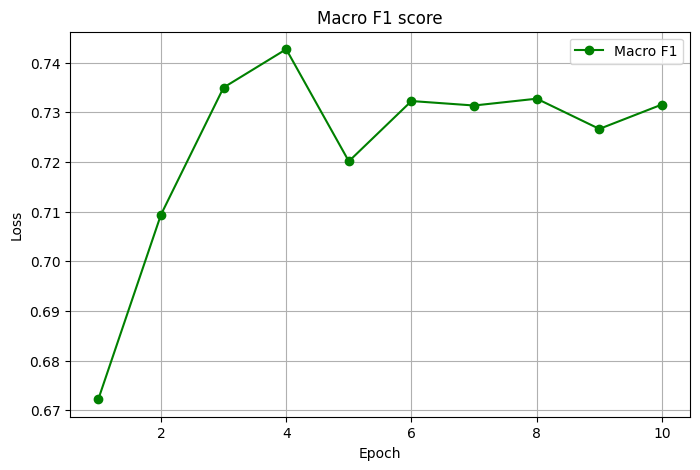

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_f1_macros, 'g-o', label='Macro F1')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Macro F1 score")
plt.legend()
plt.grid(True)
plt.show()


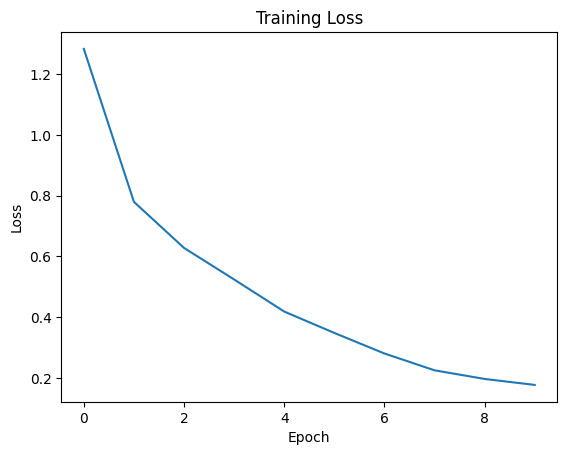

NameError: name 'f1_macros' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(f1_macros, label="Macro F1")
plt.plot(f1_weighteds, label="Weighted F1")
plt.legend()
plt.title("Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.show()
